# Comparative cluster analysis

Our greedy latent structure learner (GLSL) method has produced a model with 9 latent variables. Each latent variable groups a series of motor/non-motor symptoms. In addition, each latent variable follows a categorical distribution that can be analyzed from a clustering perspective, where a state represents a cluster.

#### Purpose

In this notebook we are going to analyze the age, sex, pd_onset, pd_durat of each cluster of each partition to observe if there are significant differences.

#### Notes

To improve the analysis we are going to rename the states of latent variables (we will also do the same on the XDSL models) and order them according to their respective symptoms intensity. This way, it will be easier to analyze the resulting plots. Once renamed we can observe that patients may belong to "low-intensity" clusters in certain partitions and to "high-intensity" clusters in other partitions.

**IMPORTANT:** While in the article we refer to tclustering "I" as the auxiliary latent variable, in the original experiments it was named "H". So take this small lack of consistency into consideration .

#### Hypothesis tests
* In the case of two clusters, we will do a Mann-Whitney U-test.
* In the case of three or more clusters, we will first do a Kruskal-Wallis test, followed by a post-hoc analysis of Tukey-HSD.

We use a significance value of 0.01. Therefore p-value should be < 0.01 for the difference between clusters to be significant.

-----

#### Load data

In [1]:
from scipy.io import arff
import pandas as pd
import numpy as np

# Load original data with socio-demographic data, the patient number and the Hoehn Yahr scale
# 24 + 6 attributes
original_data = arff.loadarff("../data/data_numerical.arff")
original_data = pd.DataFrame(original_data[0])
print(original_data.shape)

# Load partition data (data with completed partitions)
# This data has 9 extra attributes (one for each latent variable), but doesnt have socio-demographic columns because they weren't 
# used during the learning process
# 24 + 9 attributes
partitions_data = arff.loadarff("../results/glsl_cil_1_64.arff")
partitions_data = pd.DataFrame(partitions_data[0])
print(partitions_data.shape)

(402, 30)
(402, 33)


In [2]:
original_data["age"].std()

9.959031972900155

#### Object data types in UTF-8 format 

Object data types are in binary form (b'), we need to pass them to UTF-8

In [3]:
# Object data types are in binary form, we need to pass them to utf-8
object_columns = original_data.select_dtypes("object").columns
original_data[object_columns] = original_data[object_columns].stack().str.decode('utf-8').unstack()
#original_data.head()

In [4]:
# Object data types are in binary form, we need to pass them to utf-8
object_columns = partitions_data.select_dtypes("object").columns
partitions_data[object_columns] = partitions_data[object_columns].stack().str.decode('utf-8').unstack()
#partitions_data.head()

#### Subset data for analysis

In [5]:
analysis_columns = ["sex", "age", "pdonset", "durat_pd", "hy"]
data = pd.DataFrame()

data[analysis_columns] = original_data[analysis_columns]

data["A"] = partitions_data["LV_60178"]
data["B"] = partitions_data["LV_120174"]
data["C"] = partitions_data["LV_60059"]
data["D"] = partitions_data["LV_60492"]
data["E"] = partitions_data["LV_60373"]
data["F"] = partitions_data["LV_60213"]
data["G"] = partitions_data["LV_12"]
data["H"] = partitions_data["LV_120258"]
data["I"] = partitions_data["LV_34"]

# Sex as categorical data
data["sex"] = data["sex"].astype("category")

print(data.shape)

(402, 14)


#### Hoehn Yahr

In [6]:
data["hy"].describe()

count    402.000000
mean       2.253731
std        0.740896
min        1.000000
25%        2.000000
50%        2.000000
75%        3.000000
max        4.000000
Name: hy, dtype: float64

In [7]:
data["hy"].median()

2.0

In [8]:
hy_cat = pd.DataFrame()
hy_cat["hy"] = data["hy"].astype("category")

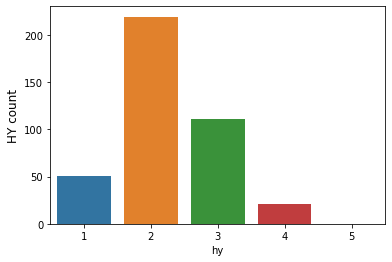

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, (ax1) = plt.subplots(ncols=1, figsize=(6, 4))
sns.countplot(x="hy", data=hy_cat, order=[1,2,3,4,5])
ax1.set_ylabel('HY count', fontsize=12)

plt.savefig("figures/hy_dist_base.pdf", format="pdf", bbox_inches='tight')

In [10]:
data["hy"].value_counts()

2.0    219
3.0    111
1.0     51
4.0     21
Name: hy, dtype: int64

----

## 1 - Clustering A

* **Attributes:** impulse\_control, pigd

#### 1.1 - Prepare data analysis

In [11]:
# First, we make this variable categorical so Pandas can order its states in the plot. Then we rename its categories accordingly (and reorder them if necessary)
data["A"] = data["A"].astype("category")
data["A"] = data["A"].cat.rename_categories({"0":"C1", "1": "C2"})
data["A"] = data["A"].cat.reorder_categories(['C1', 'C2'])

#### 1.2 - Hoehn Yahr

##### Plot

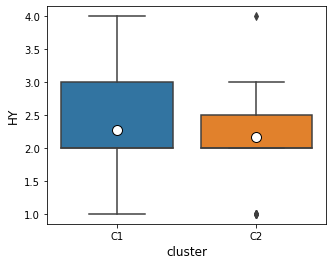

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

sex_colors = ["#00A6D6", "#FF69B4"]

fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(5, 4))

sns.boxplot(x="A", y="hy", data=data, showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"})
axs.set_ylabel('HY', fontsize=12)
axs.set_xlabel("cluster", fontsize=12)

plt.savefig("figures/hy_A_boxplot.pdf", format="pdf", bbox_inches='tight')

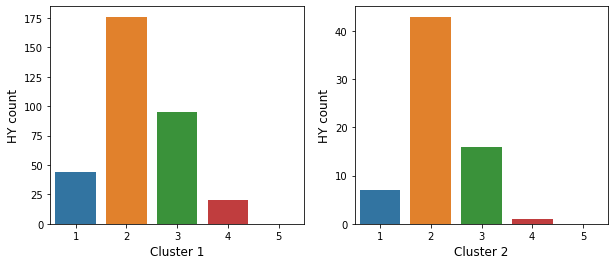

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 4))

sns.countplot(data.loc[data["A"] == "C1", "hy"], ax = axs[0], order=[1,2,3,4,5])
axs[0].set_xlabel("Cluster 1", fontsize=12)
axs[0].set_ylabel("HY count", fontsize=12)

sns.countplot(data.loc[data["A"] == "C2", "hy"], ax = axs[1], order=[1,2,3,4,5])
axs[1].set_xlabel("Cluster 2", fontsize=12)
axs[1].set_ylabel("HY count", fontsize=12)

plt.savefig("figures/hy_dists_B.pdf", format="pdf", bbox_inches='tight')

##### Table

In [14]:
partition = "A"
columns_1 = ["hy", partition]

data[columns_1].groupby([partition]).mean().round(2)
data[columns_1].groupby([partition]).std().round(2)

,hy
A,
C1,0.76
C2,0.62


##### Hypothesis test (continuous)

In [15]:
from scipy.stats import mannwhitneyu as mw

cluster_1_data = data.loc[data["A"] == "C1", "hy"]
cluster_2_data = data.loc[data["A"] == "C2", "hy"]

mw(cluster_1_data, cluster_2_data).pvalue

0.15768002352950788

##### Hypothesis test (discrete)

In [16]:
from scipy.stats import chi2_contingency 

cluster_1_data = data.loc[data["A"] == "C1", "hy"].value_counts()
cluster_2_data = data.loc[data["A"] == "C2", "hy"].value_counts()

# Given that in this dataset there are no HY values of 5, we consider only 4
cluster_1_data_array = [cluster_1_data.iloc[0], cluster_1_data.iloc[1], cluster_1_data.iloc[2], cluster_1_data.iloc[3]]
cluster_2_data_array = [cluster_2_data.iloc[0], cluster_2_data.iloc[1], cluster_2_data.iloc[2], cluster_2_data.iloc[3]]

contingency_table = [cluster_1_data_array, cluster_2_data_array]

tat, p, dof, expected = chi2_contingency(contingency_table)
p

0.23521753962087613

#### 1.3 - Age

##### Plot

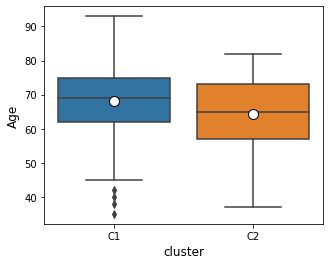

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

sex_colors = ["#00A6D6", "#FF69B4"]

fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(5, 4))

sns.boxplot(x="A", y="age", data=data, showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"})
axs.set_ylabel('Age', fontsize=12)
axs.set_xlabel("cluster", fontsize=12)

plt.savefig("figures/age_A_boxplot.pdf", format="pdf", bbox_inches='tight')

##### Table

In [18]:
partition = "A"
columns_1 = ["age", partition]

data[columns_1].groupby([partition]).mean().round(2)
data[columns_1].groupby([partition]).std().round(2)

,age
A,
C1,9.85
C2,10.02


##### Hypothesis test

In [19]:
from scipy.stats import mannwhitneyu as mw

cluster_1_data = data.loc[data["A"] == "C1", "age"]
cluster_2_data = data.loc[data["A"] == "C2", "age"]

mw(cluster_1_data, cluster_2_data).pvalue

0.007186457448389278

#### 1.4 - PD Onset

##### Plot

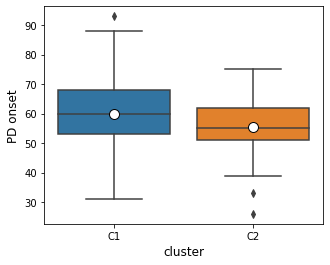

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

sex_colors = ["#00A6D6", "#FF69B4"]

fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(5, 4))

sns.boxplot(x="A", y="pdonset", data=data, showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white",
                       "markeredgecolor":"black",
                      "markersize":"10"})
axs.set_ylabel('PD onset', fontsize=12)
axs.set_xlabel("cluster", fontsize=12)

plt.savefig("figures/pdonset_A_boxplot.pdf", format="pdf", bbox_inches='tight')

##### Table

In [21]:
partition = "A"
columns_1 = ["pdonset", partition]

data[columns_1].groupby([partition]).mean().round(2)
data[columns_1].groupby([partition]).std().round(2)

,pdonset
A,
C1,10.82
C2,9.06


##### Hypothesis test

In [22]:
from scipy.stats import mannwhitneyu as mw

cluster_1_data = data.loc[data["A"] == "C1", "pdonset"]
cluster_2_data = data.loc[data["A"] == "C2", "pdonset"]

mw(cluster_1_data, cluster_2_data).pvalue

0.000505233912728712

#### 1.5 - PD duration

##### Plot

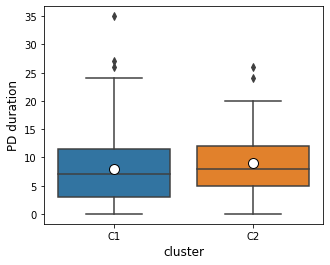

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

sex_colors = ["#00A6D6", "#FF69B4"]

fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(5, 4))

sns.boxplot(x="A", y="durat_pd", data=data, showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white",
                       "markeredgecolor":"black",
                      "markersize":"10"})
axs.set_ylabel('PD duration', fontsize=12)
axs.set_xlabel("cluster", fontsize=12)

plt.savefig("figures/durat_pd_A_boxplot.pdf", format="pdf", bbox_inches='tight')

##### Table

In [24]:
partition = "A"
columns_1 = ["durat_pd", partition]

data[columns_1].groupby([partition]).mean().round(2)
data[columns_1].groupby([partition]).std().round(2)

,durat_pd
A,
C1,5.95
C2,5.79


##### Hypothesis test

In [25]:
from scipy.stats import mannwhitneyu as mw

cluster_1_data = data.loc[data["A"] == "C1", "durat_pd"]
cluster_2_data = data.loc[data["A"] == "C2", "durat_pd"]

mw(cluster_1_data, cluster_2_data).pvalue

0.05761890926700898

#### 1.6 - Sex

##### Proporion table

Estimate the proportion of males and females in each cluster. The idea is to see if there are big proportional differences. This is not a hypothesis test.

In [26]:
import numpy as np

partition = "A"
columns_1 = ["sex", partition]

total_males = data["sex"].value_counts()[0]
total_females = data["sex"].value_counts()[1]
total = np.array([total_males, total_females, total_males, total_females])

(data[columns_1].groupby([partition]).sex.value_counts()/total * 100).round(2)

A   sex   
C1  male      83.60
    female    82.89
C2  male      16.40
    female    17.11
Name: sex, dtype: float64

##### Table

In [27]:
import numpy as np

partition = "A"
columns_1 = ["sex", partition]

cluster_1_total = data[columns_1].groupby([partition]).count().iloc[0,0]
cluster_2_total = data[columns_1].groupby([partition]).count().iloc[1,0]
total = np.array([cluster_1_total, cluster_1_total, cluster_2_total, cluster_2_total])

# Percentage
(data[columns_1].groupby([partition]).sex.value_counts()/total * 100).round(2) 
# Counts
#data[columns_1].groupby([partition]).sex.value_counts()

A   sex   
C1  male      62.39
    female    37.61
C2  male      61.19
    female    38.81
Name: sex, dtype: float64

##### Hypothesis test

Note: see https://stats.stackexchange.com/questions/110718/chi-squared-test-with-scipy-whats-the-difference-between-chi2-contingency-and

In [28]:
from scipy.stats import chisquare 

cluster_1_data = data.loc[data["A"] == "C1", "sex"].value_counts()
cluster_2_data = data.loc[data["A"] == "C2", "sex"].value_counts()

cluster_1_data_array = [cluster_1_data[0], cluster_1_data[1]] / (cluster_1_data[0] + cluster_1_data[1])
cluster_2_data_array = [cluster_2_data[0], cluster_2_data[1]] / (cluster_2_data[0] + cluster_2_data[1])

chisquare(cluster_1_data_array, cluster_2_data_array)

Power_divergenceResult(statistic=0.0006003752345215773, pvalue=0.9804517451956672)

In [29]:
from scipy.stats import chi2_contingency 

cluster_1_data = data.loc[data["A"] == "C1", "sex"].value_counts()
cluster_2_data = data.loc[data["A"] == "C2", "sex"].value_counts()

cluster_1_data_array = [cluster_1_data[0], cluster_1_data[1]]
cluster_2_data_array = [cluster_2_data[0], cluster_2_data[1]]
contingency_table = [cluster_1_data_array, cluster_2_data_array]

tat, p, dof, expected = chi2_contingency(contingency_table)
p

0.9633120738485631

----

## 2 - Clustering B

* **Attributes:** apathy, cognition, urinary, gastrointestinal, sleep, pain

#### 2.1 - Prepare data for analysis

In [30]:
# First, we make this variable categorical so Pandas can order its states in the plot. Then we rename its categories accordingly (and reorder them if necessary)
data["B"] = data["B"].astype("category")
data["B"] = data["B"].cat.rename_categories({"0":"C1", "1": "C2"})
data["B"] = data["B"].cat.reorder_categories(['C1', 'C2'])

#### 2.2 - Hoehn Yahr

##### Plot

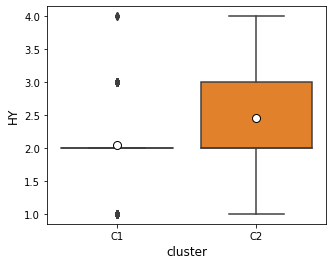

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

sex_colors = ["#00A6D6", "#FF69B4"]

fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(5, 4))

sns.boxplot(x="B", y="hy", data=data, showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"8"})
axs.set_ylabel('HY', fontsize=12)
axs.set_xlabel("cluster", fontsize=12)

plt.savefig("figures/hy_B.pdf", format="pdf", bbox_inches='tight')

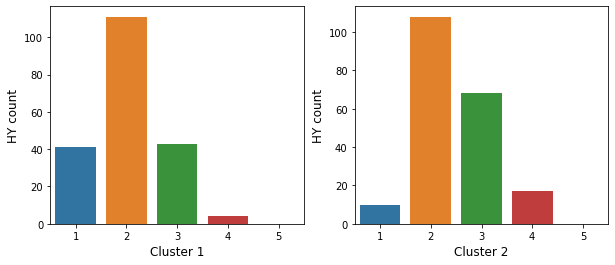

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 4))

sns.countplot(data.loc[data["B"] == "C1", "hy"], ax = axs[0], order=[1,2,3,4,5])
axs[0].set_xlabel("Cluster 1", fontsize=12)
axs[0].set_ylabel("HY count", fontsize=12)

sns.countplot(data.loc[data["B"] == "C2", "hy"], ax = axs[1], order=[1,2,3,4,5])
axs[1].set_xlabel("Cluster 2", fontsize=12)
axs[1].set_ylabel("HY count", fontsize=12)

plt.savefig("figures/hy_dists_B.pdf", format="pdf", bbox_inches='tight')

##### Table

In [33]:
partition = "B"
columns_1 = ["hy", partition]

data[columns_1].groupby([partition]).mean().round(2)
data[columns_1].groupby([partition]).std().round(2)

,hy
B,
C1,0.71
C2,0.72


##### Hypothesis test (continuous)

In [34]:
from scipy.stats import mannwhitneyu as mw

cluster_1_data = data.loc[data["B"] == "C1", "hy"]
cluster_2_data = data.loc[data["B"] == "C2", "hy"]

mw(cluster_1_data, cluster_2_data).pvalue

5.740065992465602e-08

##### Hypothesis test (discrete)

In [35]:
from scipy.stats import chi2_contingency 

cluster_1_data = data.loc[data["B"] == "C1", "hy"].value_counts()
cluster_2_data = data.loc[data["B"] == "C2", "hy"].value_counts()

# Given that in this dataset there are no HY values of 5, we consider only 4
cluster_1_data_array = [cluster_1_data.iloc[0], cluster_1_data.iloc[1], cluster_1_data.iloc[2], cluster_1_data.iloc[3]]
cluster_2_data_array = [cluster_2_data.iloc[0], cluster_2_data.iloc[1], cluster_2_data.iloc[2], cluster_2_data.iloc[3]]

contingency_table = [cluster_1_data_array, cluster_2_data_array]

tat, p, dof, expected = chi2_contingency(contingency_table)
p

0.000412299060838859

#### 2.3 - Age

##### Plot

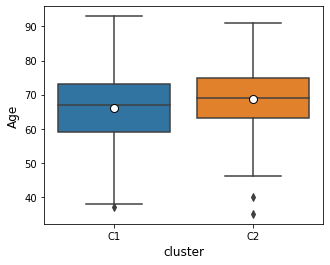

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

sex_colors = ["#00A6D6", "#FF69B4"]

fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(5, 4))

sns.boxplot(x="B", y="age", data=data, showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"8"})
axs.set_ylabel('Age', fontsize=12)
axs.set_xlabel("cluster", fontsize=12)

plt.savefig("figures/age_B.pdf", format="pdf", bbox_inches='tight')

##### Table

In [37]:
partition = "B"
columns_1 = ["age", partition]

data[columns_1].groupby([partition]).mean().round(2)
data[columns_1].groupby([partition]).std().round(2)

,age
B,
C1,10.18
C2,9.58


##### Hypothesis test

In [38]:
from scipy.stats import mannwhitneyu as mw

cluster_1_data = data.loc[data["B"] == "C1", "age"]
cluster_2_data = data.loc[data["B"] == "C2", "age"]

mw(cluster_1_data, cluster_2_data).pvalue

0.003396764364209456

#### 2.4 - PD onset

##### Plot

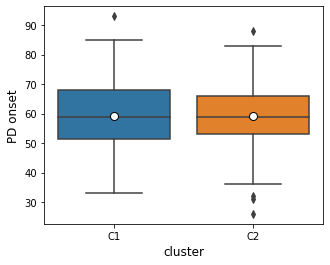

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

sex_colors = ["#00A6D6", "#FF69B4"]

fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(5, 4))

sns.boxplot(x="B", y="pdonset", data=data, showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"8"})
axs.set_ylabel('PD onset', fontsize=12)
axs.set_xlabel("cluster", fontsize=12)

plt.savefig("figures/pdonset_B.pdf", format="pdf", bbox_inches='tight')

##### Table

In [40]:
partition = "B"
columns_1 = ["pdonset", partition]

data[columns_1].groupby([partition]).mean().round(2)
data[columns_1].groupby([partition]).std().round(2)

,pdonset
B,
C1,10.79
C2,10.59


##### Hypothesis test

In [41]:
from scipy.stats import mannwhitneyu as mw

cluster_1_data = data.loc[data["B"] == "C1", "pdonset"]
cluster_2_data = data.loc[data["B"] == "C2", "pdonset"]

mw(cluster_1_data, cluster_2_data).pvalue

0.4024755021048099

#### 2.5 - PD duration

##### Plot

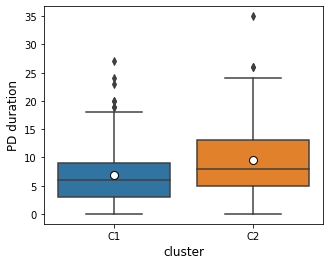

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

sex_colors = ["#00A6D6", "#FF69B4"]

fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(5, 4))

sns.boxplot(x="B", y="durat_pd", data=data, showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"8"})
axs.set_ylabel('PD duration', fontsize=12)
axs.set_xlabel("cluster", fontsize=12)

plt.savefig("figures/durat_pd_B.pdf", format="pdf", bbox_inches='tight')

##### Table

In [43]:
partition = "B"
columns_1 = ["durat_pd", partition]

data[columns_1].groupby([partition]).mean().round(2)
data[columns_1].groupby([partition]).std().round(2)

,durat_pd
B,
C1,5.15
C2,6.36


##### Hypothesis test

In [44]:
from scipy.stats import mannwhitneyu as mw

cluster_1_data = data.loc[data["B"] == "C1", "durat_pd"]
cluster_2_data = data.loc[data["B"] == "C2", "durat_pd"]

mw(cluster_1_data, cluster_2_data).pvalue

1.1244105169208302e-05

#### 2.6 - Sex

##### Proporion table

Estimate the proportion of males and females in each cluster. The idea is to see if there are big proportional differences. This is not a hypothesis test.

In [45]:
import numpy as np

partition = "B"
columns_1 = ["sex", partition]

total_males = data["sex"].value_counts()[0]
total_females = data["sex"].value_counts()[1]
total = np.array([total_males, total_females, total_males, total_females])

(data[columns_1].groupby([partition]).sex.value_counts()/total * 100).round(2)

B   sex   
C1  male      48.40
    female    51.32
C2  male      51.60
    female    48.68
Name: sex, dtype: float64

##### Table

In [46]:
import numpy as np

partition = "B"
columns_1 = ["sex", partition]

cluster_1_total = data[columns_1].groupby([partition]).count().iloc[0,0]
cluster_2_total = data[columns_1].groupby([partition]).count().iloc[1,0]
total = np.array([cluster_1_total, cluster_1_total, cluster_2_total, cluster_2_total])

# Percentage
(data[columns_1].groupby([partition]).sex.value_counts()/total * 100).round(2) 
# Counts
#data[columns_1].groupby([partition]).sex.value_counts()

B   sex   
C1  male      60.80
    female    39.20
C2  male      63.55
    female    36.45
Name: sex, dtype: float64

##### Hypothesis test

Note: see https://stats.stackexchange.com/questions/110718/chi-squared-test-with-scipy-whats-the-difference-between-chi2-contingency-and

In [47]:
from scipy.stats import chi2_contingency 

cluster_1_data = data.loc[data["B"] == "C1", "sex"].value_counts()
cluster_2_data = data.loc[data["B"] == "C2", "sex"].value_counts()

cluster_1_data_array = [cluster_1_data[0], cluster_1_data[1]]
cluster_2_data_array = [cluster_2_data[0], cluster_2_data[1]]
contingency_table = [cluster_1_data_array, cluster_2_data_array]

tat, p, dof, expected = chi2_contingency(contingency_table)
p

0.642543647376864

----

## 3 - Clustering C

* **Attributes:** dyskinesias, psychosis

#### 3.1 - Prepare data for analysis

In [48]:
# First, we make this variable categorical so Pandas can order its states in the plot. Then we rename its categories accordingly (and reorder them if necessary)
data["C"] = data["C"].astype("category")
data["C"] = data["C"].cat.rename_categories({"0":"C1", "1": "C3", "2": "C2"})
data["C"] = data["C"].cat.reorder_categories(['C1', 'C2', 'C3'])

#### 3.2 - Hoehn Yahr

##### Plot

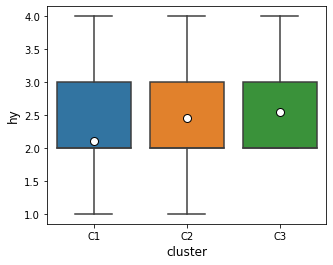

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

sex_colors = ["#00A6D6", "#FF69B4"]

fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(5, 4))

sns.boxplot(x="C", y="hy", data=data, showmeans= True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"8"})
axs.set_ylabel('hy', fontsize=12)
axs.set_xlabel("cluster", fontsize=12)

plt.savefig("figures/hy_C.pdf", format="pdf", bbox_inches='tight')

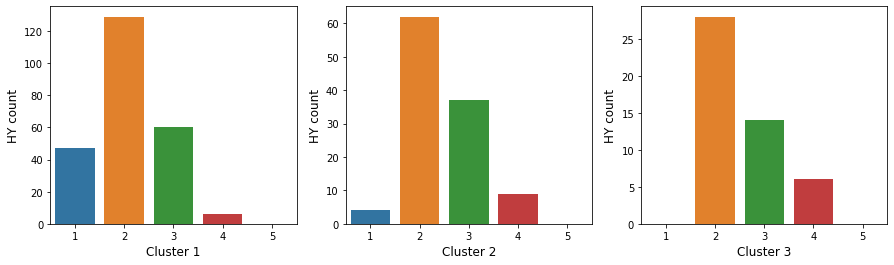

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(15, 4))

sns.countplot(data.loc[data["C"] == "C1", "hy"], ax = axs[0], order=[1,2,3,4,5])
axs[0].set_xlabel("Cluster 1", fontsize=12)
axs[0].set_ylabel("HY count", fontsize=12)

sns.countplot(data.loc[data["C"] == "C2", "hy"], ax = axs[1], order=[1,2,3,4,5])
axs[1].set_xlabel("Cluster 2", fontsize=12)
axs[1].set_ylabel("HY count", fontsize=12)

sns.countplot(data.loc[data["C"] == "C3", "hy"], ax = axs[2], order=[1,2,3,4,5])
axs[2].set_xlabel("Cluster 3", fontsize=12)
axs[2].set_ylabel("HY count", fontsize=12)

plt.savefig("figures/hy_dists_C.pdf", format="pdf", bbox_inches='tight')

##### Table

In [51]:
partition = "C"
columns_1 = ["hy", partition]

data[columns_1].groupby([partition]).mean().round(2)
data[columns_1].groupby([partition]).std().round(2)

,hy
C,
C1,0.73
C2,0.70
C3,0.71


##### Hypothesis test (continuous)
In the case of three or more clusters, we will first do a Kruskal-Wallis test, followed by a post-hoc analysis of Tukey-HSD.

In [52]:
from scipy.stats import kruskal

cluster_1_data = data.loc[data["C"] == "C1", "hy"]
cluster_2_data = data.loc[data["C"] == "C2", "hy"]
cluster_3_data = data.loc[data["C"] == "C3", "hy"]

kruskal(cluster_1_data, cluster_2_data, cluster_3_data).pvalue

1.2887261067688169e-05

Given that the Kruskal-Wallis test returns a p-value < 0.01, we can now apply the Tukey-HSD post-hoc

In [53]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

print(pairwise_tukeyhsd(endog=data["hy"], groups=data["C"]))

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
    C1     C2   0.3521  0.001  0.1588 0.5453   True
    C1     C3   0.4384  0.001  0.1712 0.7055   True
    C2     C3   0.0863 0.7458 -0.2054  0.378  False
---------------------------------------------------


##### Hypothesis test (discrete)

In [54]:
from scipy.stats import chi2_contingency 

cluster_1_data = data.loc[data["B"] == "C1", "hy"].value_counts()
cluster_2_data = data.loc[data["B"] == "C2", "hy"].value_counts()
cluster_3_data = data.loc[data["C"] == "C2", "hy"].value_counts()

# Given that in this dataset there are no HY values of 5, we consider only 4
cluster_1_data_array = [cluster_1_data.iloc[0], cluster_1_data.iloc[1], cluster_1_data.iloc[2], cluster_1_data.iloc[3]]
cluster_2_data_array = [cluster_2_data.iloc[0], cluster_2_data.iloc[1], cluster_2_data.iloc[2], cluster_2_data.iloc[3]]
cluster_3_data_array = [cluster_3_data.iloc[0], cluster_3_data.iloc[1], cluster_3_data.iloc[2], cluster_3_data.iloc[3]]

contingency_table = [cluster_1_data_array, cluster_2_data_array, cluster_3_data_array]

tat, p, dof, expected = chi2_contingency(contingency_table)
p

0.0009114308888094949

Given that the $\chi^{2}$ test with 3 groups is less than the signifcant value (0.01), we can now compare pairs of clusters

In [55]:
# Cluster 1 vs Cluster 2
contingency_table = [cluster_1_data_array, cluster_2_data_array]

tat, p, dof, expected = chi2_contingency(contingency_table)
p

0.000412299060838859

In [56]:
# Cluster 1 vs Cluster 3
contingency_table = [cluster_1_data_array, cluster_3_data_array]

tat, p, dof, expected = chi2_contingency(contingency_table)
p

0.009930396344205339

In [57]:
# Cluster 2 vs Cluster 3
contingency_table = [cluster_2_data_array, cluster_3_data_array]

tat, p, dof, expected = chi2_contingency(contingency_table)
p

0.9453981342224083

#### 3.3 - Age

##### Plot

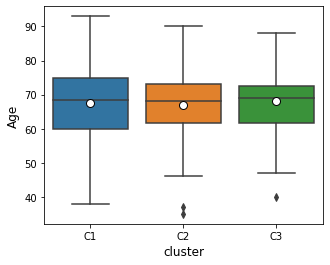

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

sex_colors = ["#00A6D6", "#FF69B4"]

fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(5, 4))

sns.boxplot(x="C", y="age", data=data, showmeans= True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"8"})
axs.set_ylabel('Age', fontsize=12)
axs.set_xlabel("cluster", fontsize=12)

plt.savefig("figures/age_C.pdf", format="pdf", bbox_inches='tight')

##### Table

In [59]:
partition = "C"
columns_1 = ["age", partition]

data[columns_1].groupby([partition]).mean().round(2)
data[columns_1].groupby([partition]).std().round(2)

,age
C,
C1,10.19
C2,9.83
C3,9.22


##### Hypothesis test
In the case of three or more clusters, we will first do a Kruskal-Wallis test, followed by a post-hoc analysis of Tukey-HSD.

In [60]:
from scipy.stats import kruskal

cluster_1_data = data.loc[data["C"] == "C1", "age"]
cluster_2_data = data.loc[data["C"] == "C2", "age"]
cluster_3_data = data.loc[data["C"] == "C3", "age"]

kruskal(cluster_1_data, cluster_2_data, cluster_3_data).pvalue

0.9021428945108091

Given that the Kruskal Wallis test returns a value that is >= 0.05, we cannot apply the post-hoc analysis.

#### 3.4 - PD onset

##### Plot

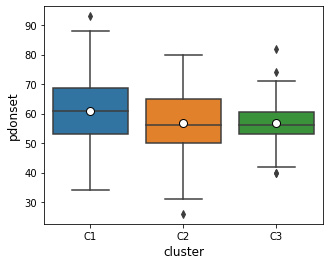

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

sex_colors = ["#00A6D6", "#FF69B4"]

fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(5, 4))

sns.boxplot(x="C", y="pdonset", data=data, showmeans= True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"8"})
axs.set_ylabel('pdonset', fontsize=12)
axs.set_xlabel("cluster", fontsize=12)

plt.savefig("figures/pdonset_C.pdf", format="pdf", bbox_inches='tight')

##### Table

In [62]:
partition = "C"
columns_1 = ["pdonset", partition]

data[columns_1].groupby([partition]).mean().round(2)
data[columns_1].groupby([partition]).std().round(2)

,pdonset
C,
C1,10.70
C2,11.00
C3,8.37


##### Hypothesis test

In [63]:
from scipy.stats import kruskal

cluster_1_data = data.loc[data["C"] == "C1", "pdonset"]
cluster_2_data = data.loc[data["C"] == "C2", "pdonset"]
cluster_3_data = data.loc[data["C"] == "C3", "pdonset"]

kruskal(cluster_1_data, cluster_2_data, cluster_3_data).pvalue

0.003629922435567138

Given that the Kruskal-Wallis test returns a p-value < 0.05, we can now apply the Tukey-HSD post-hoc

In [64]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

print(pairwise_tukeyhsd(endog=data["pdonset"], groups=data["C"]))

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
    C1     C2   -3.741 0.0058 -6.5749 -0.9071   True
    C1     C3  -3.8065  0.059 -7.7245  0.1116  False
    C2     C3  -0.0655    0.9 -4.3434  4.2124  False
----------------------------------------------------


#### 3.5 - PD duration

##### Plot

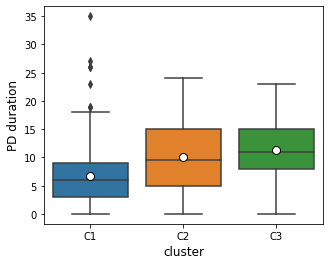

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

sex_colors = ["#00A6D6", "#FF69B4"]

fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(5, 4))

sns.boxplot(x="C", y="durat_pd", data=data, showmeans= True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"8"})
axs.set_ylabel('PD duration', fontsize=12)
axs.set_xlabel("cluster", fontsize=12)

plt.savefig("figures/durat_pd_C.pdf", format="pdf", bbox_inches='tight')

##### Table

In [66]:
partition = "C"
columns_1 = ["durat_pd", partition]

data[columns_1].groupby([partition]).mean().round(2)
data[columns_1].groupby([partition]).std().round(2)

,durat_pd
C,
C1,5.35
C2,6.19
C3,5.73


##### Hypothesis test

In [67]:
from scipy.stats import kruskal

cluster_1_data = data.loc[data["C"] == "C1", "durat_pd"]
cluster_2_data = data.loc[data["C"] == "C2", "durat_pd"]
cluster_3_data = data.loc[data["C"] == "C3", "durat_pd"]

kruskal(cluster_1_data, cluster_2_data, cluster_3_data).pvalue

3.7196933738486685e-10

In [68]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

print(pairwise_tukeyhsd(endog=data["durat_pd"], groups=data["C"]))

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
    C1     C2   3.4177  0.001  1.9017 4.9337   True
    C1     C3   4.5725  0.001  2.4765 6.6685   True
    C2     C3   1.1548 0.4634 -1.1337 3.4433  False
---------------------------------------------------


#### 3.6 - Sex

##### Proportion table

Estimate the proportion of males and females in each cluster. The idea is to see if there are big proportional differences. This is not a hypothesis test.

In [69]:
import numpy as np

partition = "C"
columns_1 = ["sex", partition]

total_males = data["sex"].value_counts()[0]
total_females = data["sex"].value_counts()[1]
total = np.array([total_males, total_females, total_males, total_females, total_males, total_females])

(data[columns_1].groupby([partition]).sex.value_counts()/total * 100).round(2)

C   sex   
C1  male      58.80
    female    62.50
C2  male      28.80
    female    26.32
C3  male      12.40
    female    11.18
Name: sex, dtype: float64

##### Table

In [70]:
import numpy as np

partition = "C"
columns_1 = ["sex", partition]

cluster_1_total = data[columns_1].groupby([partition]).count().iloc[0,0]
cluster_2_total = data[columns_1].groupby([partition]).count().iloc[1,0]
cluster_3_total = data[columns_1].groupby([partition]).count().iloc[2,0]
total = np.array([cluster_1_total, cluster_1_total, cluster_2_total, cluster_2_total, cluster_3_total, cluster_3_total])

# Percentage
(data[columns_1].groupby([partition]).sex.value_counts()/total * 100).round(2) 
# Counts
#data[columns_1].groupby([partition]).sex.value_counts()

C   sex   
C1  male      60.74
    female    39.26
C2  male      64.29
    female    35.71
C3  male      64.58
    female    35.42
Name: sex, dtype: float64

##### Hypothesis test
https://stats.stackexchange.com/questions/110718/chi-squared-test-with-scipy-whats-the-difference-between-chi2-contingency-and

In [71]:
from scipy.stats import chi2_contingency 

cluster_1_data = data.loc[data["C"] == "C1", "sex"].value_counts()
cluster_2_data = data.loc[data["C"] == "C2", "sex"].value_counts()
cluster_3_data = data.loc[data["C"] == "C3", "sex"].value_counts()

cluster_1_data_array = [cluster_1_data[0], cluster_1_data[1]]
cluster_2_data_array = [cluster_2_data[0], cluster_2_data[1]]
cluster_3_data_array = [cluster_3_data[0], cluster_3_data[1]]
contingency_table = [cluster_1_data_array, cluster_2_data_array, cluster_3_data_array]

tat, p, dof, expected = chi2_contingency(contingency_table)
p

0.7628567059418774

----
## 4 - Clustering D

* **Attributes:** mental_fatigue, physical_tiredness

#### 4.1 - Prepare data for analysis

In [72]:
# First, we make this variable categorical so Pandas can order its states in the plot. Then we rename its categories accordingly (and reorder them if necessary)
data["D"] = data["D"].astype("category")
data["D"] = data["D"].cat.rename_categories({"0":"C2", "1": "C1"})
data["D"] = data["D"].cat.reorder_categories(['C1', 'C2'])

#### 4.2 - Hoehn Yahr

##### Plot

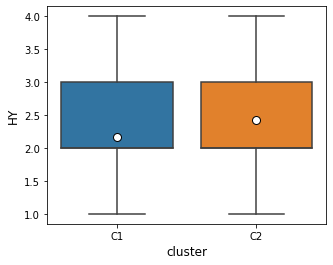

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

sex_colors = ["#00A6D6", "#FF69B4"]

fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(5, 4))

sns.boxplot(x="D", y="hy", data=data, showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"8"})
axs.set_ylabel('HY', fontsize=12)
axs.set_xlabel("cluster", fontsize=12)

plt.savefig("figures/hy_D.pdf", format="pdf", bbox_inches='tight')

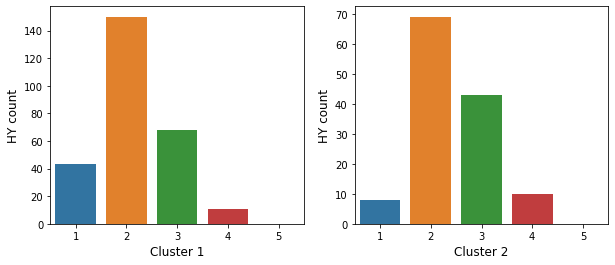

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 4))

sns.countplot(data.loc[data["D"] == "C1", "hy"], ax = axs[0], order=[1,2,3,4,5])
axs[0].set_xlabel("Cluster 1", fontsize=12)
axs[0].set_ylabel("HY count", fontsize=12)

sns.countplot(data.loc[data["D"] == "C2", "hy"], ax = axs[1], order=[1,2,3,4,5])
axs[1].set_xlabel("Cluster 2", fontsize=12)
axs[1].set_ylabel("HY count", fontsize=12)

plt.savefig("figures/hy_dists_D.pdf", format="pdf", bbox_inches='tight')

##### Table

In [75]:
partition = "D"
columns_1 = ["hy", partition]

data[columns_1].groupby([partition]).mean().round(2)
data[columns_1].groupby([partition]).std().round(2)

,hy
D,
C1,0.74
C2,0.72


##### Hypothesis test (continuous)

In [76]:
from scipy.stats import mannwhitneyu as mw

cluster_1_data = data.loc[data["D"] == "C1", "hy"]
cluster_2_data = data.loc[data["D"] == "C2", "hy"]

mw(cluster_1_data, cluster_2_data).pvalue

0.0009361311751810131

##### Hypothesis test (discrete)

In [77]:
from scipy.stats import chi2_contingency 

cluster_1_data = data.loc[data["D"] == "C1", "hy"].value_counts()
cluster_2_data = data.loc[data["D"] == "C2", "hy"].value_counts()

# Given that in this dataset there are no HY values of 5, we consider only 4
cluster_1_data_array = [cluster_1_data.iloc[0], cluster_1_data.iloc[1], cluster_1_data.iloc[2], cluster_1_data.iloc[3]]
cluster_2_data_array = [cluster_2_data.iloc[0], cluster_2_data.iloc[1], cluster_2_data.iloc[2], cluster_2_data.iloc[3]]

contingency_table = [cluster_1_data_array, cluster_2_data_array]

tat, p, dof, expected = chi2_contingency(contingency_table)
p

0.0609705810278397

#### 4.3 - Age

##### Plot

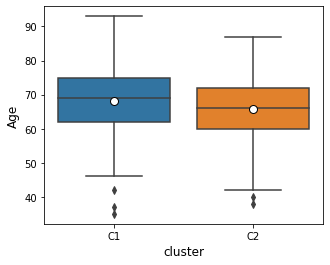

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns

sex_colors = ["#00A6D6", "#FF69B4"]

fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(5, 4))

sns.boxplot(x="D", y="age", data=data, showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"8"})
axs.set_ylabel('Age', fontsize=12)
axs.set_xlabel("cluster", fontsize=12)

plt.savefig("figures/age_D.pdf", format="pdf", bbox_inches='tight')

##### Table

In [79]:
partition = "D"
columns_1 = ["age", partition]

data[columns_1].groupby([partition]).mean().round(2)
data[columns_1].groupby([partition]).std().round(2)

,age
D,
C1,10.21
C2,9.27


##### Hypothesis test

In [80]:
from scipy.stats import mannwhitneyu as mw

cluster_1_data = data.loc[data["D"] == "C1", "age"]
cluster_2_data = data.loc[data["D"] == "C2", "age"]

mw(cluster_1_data, cluster_2_data).pvalue

0.013954139662032242

#### 4.4 - PD onset

##### Plot

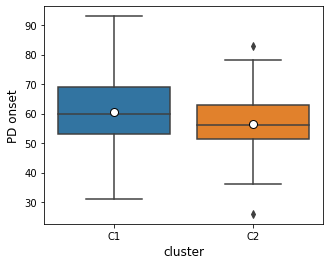

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns

sex_colors = ["#00A6D6", "#FF69B4"]

fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(5, 4))

sns.boxplot(x="D", y="pdonset", data=data, showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"8"})
axs.set_ylabel('PD onset', fontsize=12)
axs.set_xlabel("cluster", fontsize=12)

plt.savefig("figures/pdonset_D.pdf", format="pdf", bbox_inches='tight')

##### Table

In [82]:
partition = "D"
columns_1 = ["pdonset", partition]

data[columns_1].groupby([partition]).mean().round(2)
data[columns_1].groupby([partition]).std().round(2)

,pdonset
D,
C1,10.92
C2,9.66


##### Hypothesis test

In [83]:
from scipy.stats import mannwhitneyu as mw

cluster_1_data = data.loc[data["D"] == "C1", "pdonset"]
cluster_2_data = data.loc[data["D"] == "C2", "pdonset"]

mw(cluster_1_data, cluster_2_data).pvalue

0.00033118614647478404

#### 4.5 - PD duration

##### Plot

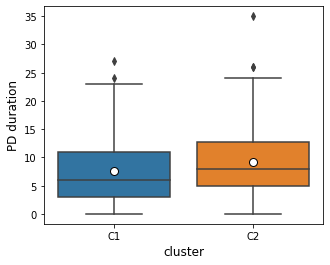

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns

sex_colors = ["#00A6D6", "#FF69B4"]

fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(5, 4))

sns.boxplot(x="D", y="durat_pd", data=data, showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"8"})
axs.set_ylabel('PD duration', fontsize=12)
axs.set_xlabel("cluster", fontsize=12)

plt.savefig("figures/durat_pd_D.pdf", format="pdf", bbox_inches='tight')

##### Table

In [85]:
partition = "D"
columns_1 = ["durat_pd", partition]

data[columns_1].groupby([partition]).mean().round(2)
data[columns_1].groupby([partition]).std().round(2)

,durat_pd
D,
C1,5.65
C2,6.36


##### Hypothesis test

In [86]:
from scipy.stats import mannwhitneyu as mw

cluster_1_data = data.loc[data["D"] == "C1", "durat_pd"]
cluster_2_data = data.loc[data["D"] == "C2", "durat_pd"]

mw(cluster_1_data, cluster_2_data).pvalue

0.007678960831583254

#### 4.6 - Sex

##### Proportion table

Estimate the proportion of males and females in each cluster. The idea is to see if there are big proportional differences. This is not a hypothesis test.

In [87]:
import numpy as np

partition = "D"
columns_1 = ["sex", partition]

total_males = data["sex"].value_counts()[0]
total_females = data["sex"].value_counts()[1]
total = np.array([total_males, total_females, total_males, total_females])

(data[columns_1].groupby([partition]).sex.value_counts()/total * 100).round(2)

D   sex   
C1  male      67.20
    female    68.42
C2  male      32.80
    female    31.58
Name: sex, dtype: float64

##### Table

In [88]:
import numpy as np

partition = "D"
columns_1 = ["sex", partition]

cluster_1_total = data[columns_1].groupby([partition]).count().iloc[0,0]
cluster_2_total = data[columns_1].groupby([partition]).count().iloc[1,0]
total = np.array([cluster_1_total, cluster_1_total, cluster_2_total, cluster_2_total])

# Percentage
(data[columns_1].groupby([partition]).sex.value_counts()/total * 100).round(2) 
# Counts
#data[columns_1].groupby([partition]).sex.value_counts()

D   sex   
C1  male      61.76
    female    38.24
C2  male      63.08
    female    36.92
Name: sex, dtype: float64

##### Hypothesis test
https://stats.stackexchange.com/questions/110718/chi-squared-test-with-scipy-whats-the-difference-between-chi2-contingency-and

In [89]:
from scipy.stats import chi2_contingency 

cluster_1_data = data.loc[data["D"] == "C1", "sex"].value_counts()
cluster_2_data = data.loc[data["D"] == "C2", "sex"].value_counts()

cluster_1_data_array = [cluster_1_data[0], cluster_1_data[1]]
cluster_2_data_array = [cluster_2_data[0], cluster_2_data[1]]
contingency_table = [cluster_1_data_array, cluster_2_data_array]

tat, p, dof, expected = chi2_contingency(contingency_table)
p

0.8856160465609243

----

## 5 - Clustering E

* **Attributes:** fluctuations, smell, axial_no_pigd, bradykinesia

#### 5.1 - Prepare data for analysis

In [90]:
# First, we make this variable categorical so Pandas can order its states in the plot. Then we rename its categories accordingly (and reorder them if necessary)
data["E"] = data["E"].astype("category")
data["E"] = data["E"].cat.rename_categories({"0":"C2", "1": "C1"})
data["E"] = data["E"].cat.reorder_categories(['C1', 'C2'])

#### 5.2 - Hoehn Yahr

##### Plot

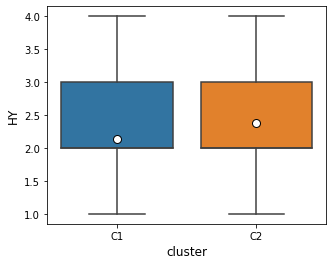

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns

sex_colors = ["#00A6D6", "#FF69B4"]

fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(5, 4))

sns.boxplot(x="E", y="hy", data=data, showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"8"})
axs.set_ylabel('HY', fontsize=12)
axs.set_xlabel("cluster", fontsize=12)

plt.savefig("figures/hy_E.pdf", format="pdf", bbox_inches='tight')

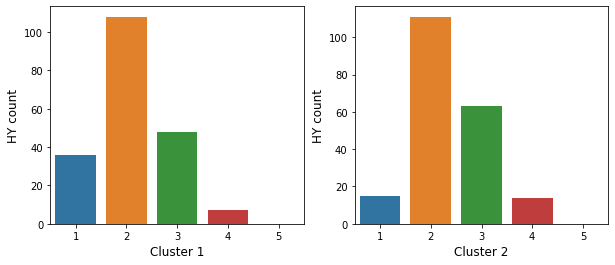

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 4))

sns.countplot(data.loc[data["E"] == "C1", "hy"], ax = axs[0], order=[1,2,3,4,5])
axs[0].set_xlabel("Cluster 1", fontsize=12)
axs[0].set_ylabel("HY count", fontsize=12)

sns.countplot(data.loc[data["E"] == "C2", "hy"], ax = axs[1], order=[1,2,3,4,5])
axs[1].set_xlabel("Cluster 2", fontsize=12)
axs[1].set_ylabel("HY count", fontsize=12)

plt.savefig("figures/hy_dists_E.pdf", format="pdf", bbox_inches='tight')

##### Table

In [93]:
partition = "E"
columns_1 = ["hy", partition]

data[columns_1].groupby([partition]).mean().round(2)
data[columns_1].groupby([partition]).std().round(2)

,hy
E,
C1,0.74
C2,0.72


##### Hypothesis test (continuous)

In [94]:
from scipy.stats import mannwhitneyu as mw

cluster_1_data = data.loc[data["E"] == "C1", "hy"]
cluster_2_data = data.loc[data["E"] == "C2", "hy"]

mw(cluster_1_data, cluster_2_data).pvalue

0.0006496447371257652

##### Hypothesis test (discrete)

In [95]:
from scipy.stats import chi2_contingency 

cluster_1_data = data.loc[data["E"] == "C1", "hy"].value_counts()
cluster_2_data = data.loc[data["E"] == "C2", "hy"].value_counts()

# Given that in this dataset there are no HY values of 5, we consider only 4
cluster_1_data_array = [cluster_1_data.iloc[0], cluster_1_data.iloc[1], cluster_1_data.iloc[2], cluster_1_data.iloc[3]]
cluster_2_data_array = [cluster_2_data.iloc[0], cluster_2_data.iloc[1], cluster_2_data.iloc[2], cluster_2_data.iloc[3]]

contingency_table = [cluster_1_data_array, cluster_2_data_array]

tat, p, dof, expected = chi2_contingency(contingency_table)
p

0.004615025031847256

#### 5.3 - Age

##### Plot

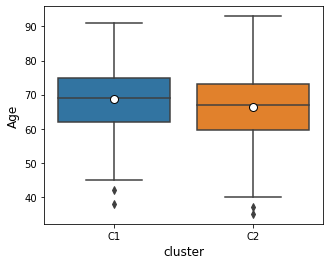

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns

sex_colors = ["#00A6D6", "#FF69B4"]

fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(5, 4))

sns.boxplot(x="E", y="age", data=data, showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"8"})
axs.set_ylabel('Age', fontsize=12)
axs.set_xlabel("cluster", fontsize=12)

plt.savefig("figures/age_E.pdf", format="pdf", bbox_inches='tight')

##### Table

In [97]:
partition = "E"
columns_1 = ["age", partition]

data[columns_1].groupby([partition]).mean().round(2)
data[columns_1].groupby([partition]).std().round(2)

,age
E,
C1,9.75
C2,10.05


##### Hypothesis test

In [98]:
from scipy.stats import mannwhitneyu as mw

cluster_1_data = data.loc[data["E"] == "C1", "age"]
cluster_2_data = data.loc[data["E"] == "C2", "age"]

mw(cluster_1_data, cluster_2_data).pvalue

0.006664389275025448

#### 5.4 - PD onset

##### Plot

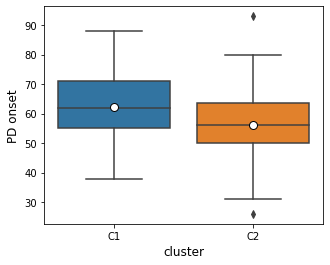

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns

sex_colors = ["#00A6D6", "#FF69B4"]

fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(5, 4))

sns.boxplot(x="E", y="pdonset", data=data, showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"8"})
axs.set_ylabel('PD onset', fontsize=12)
axs.set_xlabel("cluster", fontsize=12)

plt.savefig("figures/pdonset_E.pdf", format="pdf", bbox_inches='tight')

##### Table

In [100]:
partition = "E"
columns_1 = ["pdonset", partition]

data[columns_1].groupby([partition]).mean().round(2)
data[columns_1].groupby([partition]).std().round(2)

,pdonset
E,
C1,10.26
C2,10.26


##### Hypothesis test

In [101]:
from scipy.stats import mannwhitneyu as mw

cluster_1_data = data.loc[data["E"] == "C1", "pdonset"]
cluster_2_data = data.loc[data["E"] == "C2", "pdonset"]

mw(cluster_1_data, cluster_2_data).pvalue

8.970386616526388e-09

#### 5.5 - PD duration

##### Plot

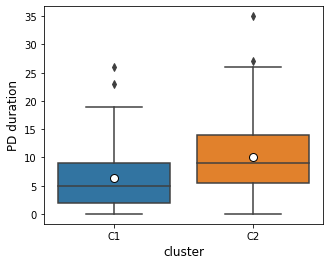

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns

sex_colors = ["#00A6D6", "#FF69B4"]

fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(5, 4))

sns.boxplot(x="E", y="durat_pd", data=data, showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"8"})
axs.set_ylabel('PD duration', fontsize=12)
axs.set_xlabel("cluster", fontsize=12)

plt.savefig("figures/durat_pd_E.pdf", format="pdf", bbox_inches='tight')

##### Table

In [103]:
partition = "E"
columns_1 = ["durat_pd", partition]

data[columns_1].groupby([partition]).mean().round(2)
data[columns_1].groupby([partition]).std().round(2)

,durat_pd
E,
C1,5.18
C2,6.08


##### Hypothesis test

In [104]:
from scipy.stats import mannwhitneyu as mw

cluster_1_data = data.loc[data["E"] == "C1", "durat_pd"]
cluster_2_data = data.loc[data["E"] == "C2", "durat_pd"]

mw(cluster_1_data, cluster_2_data).pvalue

3.414042691767772e-11

#### 5.6 - Sex

##### Proportion table

Estimate the proportion of males and females in each cluster. The idea is to see if there are big proportional differences. This is not a hypothesis test.

In [105]:
import numpy as np

partition = "E"
columns_1 = ["sex", partition]

total_males = data["sex"].value_counts()[0]
total_females = data["sex"].value_counts()[1]
total = np.array([total_males, total_females, total_males, total_females])

(data[columns_1].groupby([partition]).sex.value_counts()/total * 100).round(2)

E   sex   
C1  male      50.40
    female    48.03
C2  male      49.60
    female    51.97
Name: sex, dtype: float64

##### Table

In [106]:
import numpy as np

partition = "E"
columns_1 = ["sex", partition]

cluster_1_total = data[columns_1].groupby([partition]).count().iloc[0,0]
cluster_2_total = data[columns_1].groupby([partition]).count().iloc[1,0]
total = np.array([cluster_1_total, cluster_1_total, cluster_2_total, cluster_2_total])

# Percentage
(data[columns_1].groupby([partition]).sex.value_counts()/total * 100).round(2) 
# Counts
#data[columns_1].groupby([partition]).sex.value_counts()

E   sex   
C1  male      63.32
    female    36.68
C2  male      61.08
    female    38.92
Name: sex, dtype: float64

##### Hypothesis test

https://stats.stackexchange.com/questions/110718/chi-squared-test-with-scipy-whats-the-difference-between-chi2-contingency-and

In [107]:
from scipy.stats import chi2_contingency 

cluster_1_data = data.loc[data["E"] == "C1", "sex"].value_counts()
cluster_2_data = data.loc[data["E"] == "C2", "sex"].value_counts()

cluster_1_data_array = [cluster_1_data[0], cluster_1_data[1]]
cluster_2_data_array = [cluster_2_data[0], cluster_2_data[1]]
contingency_table = [cluster_1_data_array, cluster_2_data_array]

tat, p, dof, expected = chi2_contingency(contingency_table)
p

0.719798942589975

----

## 6 - Clustering F

* **Attributes:** hypotension, sexual

#### 6.1 - Prepare data for analysis

In [108]:
# First, we make this variable categorical so Pandas can order its states in the plot. Then we rename its categories accordingly (and reorder them if necessary)
data["F"] = data["F"].astype("category")
data["F"] = data["F"].cat.rename_categories({"0":"C2", "1": "C1"})
data["F"] = data["F"].cat.reorder_categories(['C1', 'C2'])

#### 6.2 - Hoehn Yahr

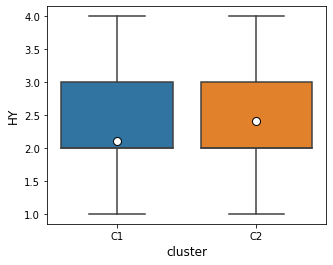

In [109]:
import matplotlib.pyplot as plt
import seaborn as sns

sex_colors = ["#00A6D6", "#FF69B4"]

fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(5, 4))

sns.boxplot(x="F", y="hy", data=data, showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"8"})
axs.set_ylabel('HY', fontsize=12)
axs.set_xlabel("cluster", fontsize=12)

plt.savefig("figures/hy_F.pdf", format="pdf", bbox_inches='tight')

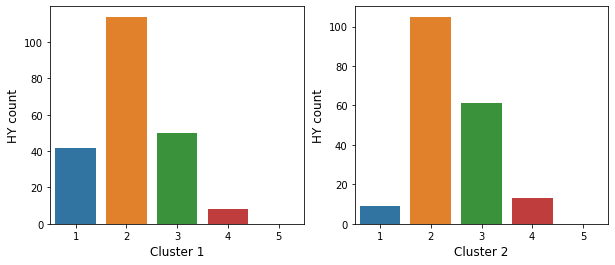

In [110]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 4))

sns.countplot(data.loc[data["F"] == "C1", "hy"], ax = axs[0], order=[1,2,3,4,5])
axs[0].set_xlabel("Cluster 1", fontsize=12)
axs[0].set_ylabel("HY count", fontsize=12)

sns.countplot(data.loc[data["F"] == "C2", "hy"], ax = axs[1], order=[1,2,3,4,5])
axs[1].set_xlabel("Cluster 2", fontsize=12)
axs[1].set_ylabel("HY count", fontsize=12)

plt.savefig("figures/hy_dists_F.pdf", format="pdf", bbox_inches='tight')

##### Table

In [111]:
partition = "F"
columns_1 = ["hy", partition]

data[columns_1].groupby([partition]).mean().round(2)
data[columns_1].groupby([partition]).std().round(2)

,hy
F,
C1,0.75
C2,0.69


##### Hypothesis test (continuous)

In [112]:
from scipy.stats import mannwhitneyu as mw

cluster_1_data = data.loc[data["F"] == "C1", "hy"]
cluster_2_data = data.loc[data["F"] == "C2", "hy"]

mw(cluster_1_data, cluster_2_data).pvalue

2.685258542887098e-05

##### Hypothesis test (discrete)

In [113]:
from scipy.stats import chi2_contingency 

cluster_1_data = data.loc[data["F"] == "C1", "hy"].value_counts()
cluster_2_data = data.loc[data["F"] == "C2", "hy"].value_counts()

# Given that in this dataset there are no HY values of 5, we consider only 4
cluster_1_data_array = [cluster_1_data.iloc[0], cluster_1_data.iloc[1], cluster_1_data.iloc[2], cluster_1_data.iloc[3]]
cluster_2_data_array = [cluster_2_data.iloc[0], cluster_2_data.iloc[1], cluster_2_data.iloc[2], cluster_2_data.iloc[3]]

contingency_table = [cluster_1_data_array, cluster_2_data_array]

tat, p, dof, expected = chi2_contingency(contingency_table)
p

0.0016599900433275343

#### 6.3 - Age

##### Plot

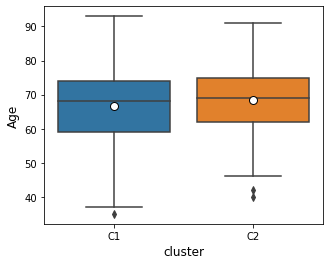

In [114]:
import matplotlib.pyplot as plt
import seaborn as sns

sex_colors = ["#00A6D6", "#FF69B4"]

fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(5, 4))

sns.boxplot(x="F", y="age", data=data, showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"8"})
axs.set_ylabel('Age', fontsize=12)
axs.set_xlabel("cluster", fontsize=12)

plt.savefig("figures/age_F.pdf", format="pdf", bbox_inches='tight')

##### Table

In [115]:
partition = "F"
columns_1 = ["age", partition]

data[columns_1].groupby([partition]).mean().round(2)
data[columns_1].groupby([partition]).std().round(2)

,age
F,
C1,10.49
C2,9.26


##### Hypothesis test

In [116]:
from scipy.stats import mannwhitneyu as mw

cluster_1_data = data.loc[data["F"] == "C1", "age"]
cluster_2_data = data.loc[data["F"] == "C2", "age"]

mw(cluster_1_data, cluster_2_data).pvalue

0.055834386821742195

#### 6.4 - PD onset

##### Plot

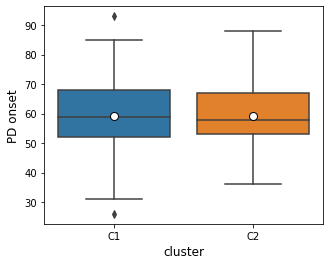

In [117]:
import matplotlib.pyplot as plt
import seaborn as sns

sex_colors = ["#00A6D6", "#FF69B4"]

fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(5, 4))

sns.boxplot(x="F", y="pdonset", data=data, showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"8"})
axs.set_ylabel('PD onset', fontsize=12)
axs.set_xlabel("cluster", fontsize=12)

plt.savefig("figures/pdonset_F.pdf", format="pdf", bbox_inches='tight')

##### Table

In [118]:
partition = "F"
columns_1 = ["pdonset", partition]

data[columns_1].groupby([partition]).mean().round(2)
data[columns_1].groupby([partition]).std().round(2)

,pdonset
F,
C1,11.04
C2,10.27


##### Hypothesis test

In [119]:
from scipy.stats import mannwhitneyu as mw

cluster_1_data = data.loc[data["F"] == "C1", "pdonset"]
cluster_2_data = data.loc[data["F"] == "C2", "pdonset"]

mw(cluster_1_data, cluster_2_data).pvalue

0.3936460089674513

#### 6.5 - PD duration

##### Plot

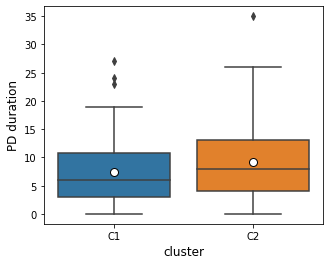

In [120]:
import matplotlib.pyplot as plt
import seaborn as sns

sex_colors = ["#00A6D6", "#FF69B4"]

fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(5, 4))

sns.boxplot(x="F", y="durat_pd", data=data, showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"8"})
axs.set_ylabel('PD duration', fontsize=12)
axs.set_xlabel("cluster", fontsize=12)

plt.savefig("figures/durat_pd_F.pdf", format="pdf", bbox_inches='tight')

##### Table

In [121]:
partition = "F"
columns_1 = ["durat_pd", partition]

data[columns_1].groupby([partition]).mean().round(2)
data[columns_1].groupby([partition]).std().round(2)

,durat_pd
F,
C1,5.29
C2,6.46


##### Hypothesis test

In [122]:
from scipy.stats import mannwhitneyu as mw

cluster_1_data = data.loc[data["F"] == "C1", "durat_pd"]
cluster_2_data = data.loc[data["F"] == "C2", "durat_pd"]

mw(cluster_1_data, cluster_2_data).pvalue

0.0031834268225661385

#### 6.6 - Sex

##### Proportion table

Estimate the proportion of males and females in each cluster. The idea is to see if there are big proportional differences. This is not a hypothesis test.

In [123]:
import numpy as np

partition = "F"
columns_1 = ["sex", partition]

total_males = data["sex"].value_counts()[0]
total_females = data["sex"].value_counts()[1]
total = np.array([total_males, total_females, total_males, total_females])

(data[columns_1].groupby([partition]).sex.value_counts()/total * 100).round(2)

F   sex   
C1  male      46.80
    female    63.82
C2  male      53.20
    female    36.18
Name: sex, dtype: float64

##### Table

In [124]:
import numpy as np

partition = "F"
columns_1 = ["sex", partition]

cluster_1_total = data[columns_1].groupby([partition]).count().iloc[0,0]
cluster_2_total = data[columns_1].groupby([partition]).count().iloc[1,0]
total = np.array([cluster_1_total, cluster_1_total, cluster_2_total, cluster_2_total])

# Percentage
(data[columns_1].groupby([partition]).sex.value_counts()/total * 100).round(2) 
# Counts
#data[columns_1].groupby([partition]).sex.value_counts()

F   sex   
C1  male      54.67
    female    45.33
C2  male      70.74
    female    29.26
Name: sex, dtype: float64

##### Hypothesis test

https://stats.stackexchange.com/questions/110718/chi-squared-test-with-scipy-whats-the-difference-between-chi2-contingency-and

In [125]:
from scipy.stats import chi2_contingency 

cluster_1_data = data.loc[data["F"] == "C1", "sex"].value_counts()
cluster_2_data = data.loc[data["F"] == "C2", "sex"].value_counts()

cluster_1_data_array = [cluster_1_data[0], cluster_1_data[1]]
cluster_2_data_array = [cluster_2_data[0], cluster_2_data[1]]
contingency_table = [cluster_1_data_array, cluster_2_data_array]

tat, p, dof, expected = chi2_contingency(contingency_table)
p

0.0013153989866391096

## 7 - Clustering G

* **Attributes:** depression, weight_loss

#### 7.1 - Prepare data for analysis

In [126]:
# First, we make this variable categorical so Pandas can order its states in the plot. Then we rename its categories accordingly (and reorder them if necessary)
data["G"] = data["G"].astype("category")
data["G"] = data["G"].cat.rename_categories({"0":"C1", "1": "C2"})
data["G"] = data["G"].cat.reorder_categories(['C1', 'C2'])

#### 7.2 - Hoehn Yahr

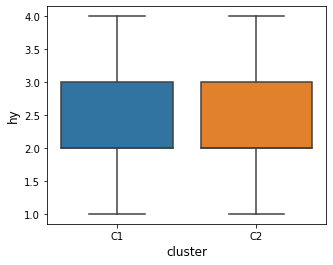

In [127]:
import matplotlib.pyplot as plt
import seaborn as sns

sex_colors = ["#00A6D6", "#FF69B4"]

fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(5, 4))

sns.boxplot(x="G", y="hy", data=data)
axs.set_ylabel('hy', fontsize=12)
axs.set_xlabel("cluster", fontsize=12)

plt.savefig("figures/hy_G.pdf", format="pdf", bbox_inches='tight')

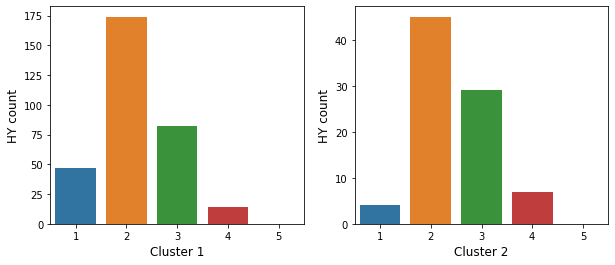

In [128]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 4))

sns.countplot(data.loc[data["G"] == "C1", "hy"], ax = axs[0], order=[1,2,3,4,5])
axs[0].set_xlabel("Cluster 1", fontsize=12)
axs[0].set_ylabel("HY count", fontsize=12)

sns.countplot(data.loc[data["G"] == "C2", "hy"], ax = axs[1], order=[1,2,3,4,5])
axs[1].set_xlabel("Cluster 2", fontsize=12)
axs[1].set_ylabel("HY count", fontsize=12)

plt.savefig("figures/hy_dists_G.pdf", format="pdf", bbox_inches='tight')

##### Table

In [129]:
partition = "G"
columns_1 = ["hy", partition]

data[columns_1].groupby([partition]).mean().round(2)
data[columns_1].groupby([partition]).std().round(2)

,hy
G,
C1,0.74
C2,0.72


##### Hypothesis test (continuous)

In [130]:
from scipy.stats import mannwhitneyu as mw

cluster_1_data = data.loc[data["G"] == "C1", "hy"]
cluster_2_data = data.loc[data["G"] == "C2", "hy"]

mw(cluster_1_data, cluster_2_data).pvalue

0.002426401294127859

##### Hypothesis test (discrete)

In [131]:
from scipy.stats import chi2_contingency 

cluster_1_data = data.loc[data["G"] == "C1", "hy"].value_counts()
cluster_2_data = data.loc[data["G"] == "C2", "hy"].value_counts()

# Given that in this dataset there are no HY values of 5, we consider only 4
cluster_1_data_array = [cluster_1_data.iloc[0], cluster_1_data.iloc[1], cluster_1_data.iloc[2], cluster_1_data.iloc[3]]
cluster_2_data_array = [cluster_2_data.iloc[0], cluster_2_data.iloc[1], cluster_2_data.iloc[2], cluster_2_data.iloc[3]]

contingency_table = [cluster_1_data_array, cluster_2_data_array]

tat, p, dof, expected = chi2_contingency(contingency_table)
p

0.27479777294557

#### 7.3 - Age

##### Plot

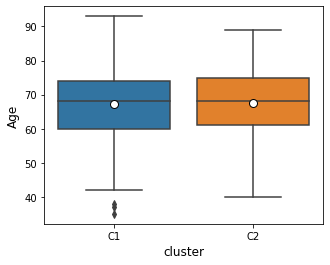

In [132]:
import matplotlib.pyplot as plt
import seaborn as sns

sex_colors = ["#00A6D6", "#FF69B4"]

fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(5, 4))

sns.boxplot(x="G", y="age", data=data, showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"8"})
axs.set_ylabel('Age', fontsize=12)
axs.set_xlabel("cluster", fontsize=12)

plt.savefig("figures/age_G.pdf", format="pdf", bbox_inches='tight')

##### Table

In [133]:
partition = "G"
columns_1 = ["age", partition]

data[columns_1].groupby([partition]).mean().round(2)
data[columns_1].groupby([partition]).std().round(2)

,age
G,
C1,10.16
C2,9.24


##### Hypothesis test

In [134]:
from scipy.stats import mannwhitneyu as mw

cluster_1_data = data.loc[data["G"] == "C1", "age"]
cluster_2_data = data.loc[data["G"] == "C2", "age"]

mw(cluster_1_data, cluster_2_data).pvalue

0.4298694845433284

#### 7.4 - PD onset

##### Plot

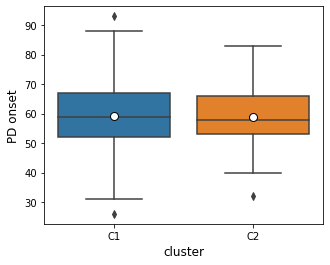

In [135]:
import matplotlib.pyplot as plt
import seaborn as sns

sex_colors = ["#00A6D6", "#FF69B4"]

fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(5, 4))

sns.boxplot(x="G", y="pdonset", data=data, showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"8"})
axs.set_ylabel('PD onset', fontsize=12)
axs.set_xlabel("cluster", fontsize=12)

plt.savefig("figures/pdonset_G.pdf", format="pdf", bbox_inches='tight')

##### Table

In [136]:
partition = "G"
columns_1 = ["pdonset", partition]

data[columns_1].groupby([partition]).mean().round(2)
data[columns_1].groupby([partition]).std().round(2)

,pdonset
G,
C1,10.86
C2,10.02


##### Hypothesis test

In [137]:
from scipy.stats import mannwhitneyu as mw

cluster_1_data = data.loc[data["G"] == "C1", "pdonset"]
cluster_2_data = data.loc[data["G"] == "C2", "pdonset"]

mw(cluster_1_data, cluster_2_data).pvalue

0.35248622762809545

#### 7.5 - PD duration

##### Plot

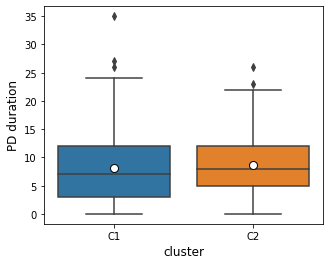

In [138]:
import matplotlib.pyplot as plt
import seaborn as sns

sex_colors = ["#00A6D6", "#FF69B4"]

fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(5, 4))

sns.boxplot(x="G", y="durat_pd", data=data, showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"8"})
axs.set_ylabel('PD duration', fontsize=12)
axs.set_xlabel("cluster", fontsize=12)

plt.savefig("figures/durat_pd_G.pdf", format="pdf", bbox_inches='tight')

##### Table

In [139]:
partition = "G"
columns_1 = ["durat_pd", partition]

data[columns_1].groupby([partition]).mean().round(2)
data[columns_1].groupby([partition]).std().round(2)

,durat_pd
G,
C1,5.93
C2,5.93


##### Hypothesis test

In [140]:
from scipy.stats import mannwhitneyu as mw

cluster_1_data = data.loc[data["G"] == "C1", "durat_pd"]
cluster_2_data = data.loc[data["G"] == "C2", "durat_pd"]

mw(cluster_1_data, cluster_2_data).pvalue

0.13497531794015516

#### 7.6 - Sex

##### Proportion table

Estimate the proportion of males and females in each cluster. The idea is to see if there are big proportional differences. This is not a hypothesis test.

In [141]:
import numpy as np

partition = "G"
columns_1 = ["sex", partition]

total_males = data["sex"].value_counts()[0]
total_females = data["sex"].value_counts()[1]
total = np.array([total_males, total_females, total_males, total_females])

(data[columns_1].groupby([partition]).sex.value_counts()/total * 100).round(2)

G   sex   
C1  male      80.00
    female    76.97
C2  male      20.00
    female    23.03
Name: sex, dtype: float64

##### Table

In [142]:
import numpy as np

partition = "G"
columns_1 = ["sex", partition]

cluster_1_total = data[columns_1].groupby([partition]).count().iloc[0,0]
cluster_2_total = data[columns_1].groupby([partition]).count().iloc[1,0]
total = np.array([cluster_1_total, cluster_1_total, cluster_2_total, cluster_2_total])

# Percentage
(data[columns_1].groupby([partition]).sex.value_counts()/total * 100).round(2) 
# Counts
#data[columns_1].groupby([partition]).sex.value_counts()

G   sex   
C1  male      63.09
    female    36.91
C2  male      58.82
    female    41.18
Name: sex, dtype: float64

##### Hypothesis test

https://stats.stackexchange.com/questions/110718/chi-squared-test-with-scipy-whats-the-difference-between-chi2-contingency-and

In [143]:
from scipy.stats import chi2_contingency 

cluster_1_data = data.loc[data["G"] == "C1", "sex"].value_counts()
cluster_2_data = data.loc[data["G"] == "C2", "sex"].value_counts()

cluster_1_data_array = [cluster_1_data[0], cluster_1_data[1]]
cluster_2_data_array = [cluster_2_data[0], cluster_2_data[1]]
contingency_table = [cluster_1_data_array, cluster_2_data_array]

tat, p, dof, expected = chi2_contingency(contingency_table)
p

0.5520894211782261

-----

## 8 - Clustering H

* This latent variable has no directly associated attributes, it simlpy relates partitions G and I.

#### 8.1 - Prepare data for analysis

In [144]:
# First, we make this variable categorical so Pandas can order its states in the plot. Then we rename its categories accordingly (and reorder them if necessary)
data["H"] = data["H"].astype("category")
data["H"] = data["H"].cat.rename_categories({"0":"C1", "1": "C2"})
data["H"] = data["H"].cat.reorder_categories(['C1', 'C2'])

#### 8.2 - Hoehn Yahr

##### Plot

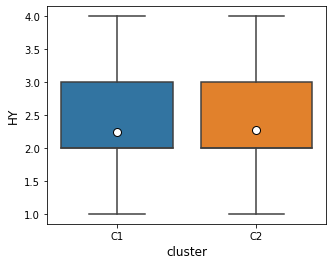

In [145]:
import matplotlib.pyplot as plt
import seaborn as sns

sex_colors = ["#00A6D6", "#FF69B4"]

fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(5, 4))

sns.boxplot(x="H", y="hy", data=data, showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"8"})
axs.set_ylabel('HY', fontsize=12)
axs.set_xlabel("cluster", fontsize=12)

plt.savefig("figures/hy_H.pdf", format="pdf", bbox_inches='tight')

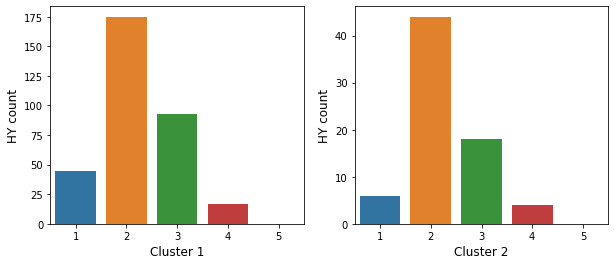

In [146]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 4))

sns.countplot(data.loc[data["H"] == "C1", "hy"], ax = axs[0], order=[1,2,3,4,5])
axs[0].set_xlabel("Cluster 1", fontsize=12)
axs[0].set_ylabel("HY count", fontsize=12)

sns.countplot(data.loc[data["H"] == "C2", "hy"], ax = axs[1], order=[1,2,3,4,5])
axs[1].set_xlabel("Cluster 2", fontsize=12)
axs[1].set_ylabel("HY count", fontsize=12)

plt.savefig("figures/hy_dists_H.pdf", format="pdf", bbox_inches='tight')

##### Table

In [147]:
partition = "H"
columns_1 = ["hy", partition]

data[columns_1].groupby([partition]).mean().round(2)
data[columns_1].groupby([partition]).std().round(2)

,hy
H,
C1,0.75
C2,0.70


##### Hypothesis test (continuous)

In [148]:
from scipy.stats import mannwhitneyu as mw

cluster_1_data = data.loc[data["H"] == "C1", "hy"]
cluster_2_data = data.loc[data["H"] == "C2", "hy"]

mw(cluster_1_data, cluster_2_data).pvalue

0.41773337444528524

##### Hypothesis test (discrete)

In [149]:
from scipy.stats import chi2_contingency 

cluster_1_data = data.loc[data["H"] == "C1", "hy"].value_counts()
cluster_2_data = data.loc[data["H"] == "C2", "hy"].value_counts()

# Given that in this dataset there are no HY values of 5, we consider only 4
cluster_1_data_array = [cluster_1_data.iloc[0], cluster_1_data.iloc[1], cluster_1_data.iloc[2], cluster_1_data.iloc[3]]
cluster_2_data_array = [cluster_2_data.iloc[0], cluster_2_data.iloc[1], cluster_2_data.iloc[2], cluster_2_data.iloc[3]]

contingency_table = [cluster_1_data_array, cluster_2_data_array]

tat, p, dof, expected = chi2_contingency(contingency_table)
p

0.5214307126264315

#### 8.3 - Age

##### Plot

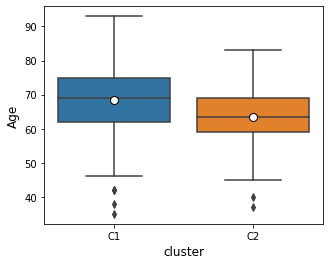

In [150]:
import matplotlib.pyplot as plt
import seaborn as sns

sex_colors = ["#00A6D6", "#FF69B4"]

fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(5, 4))

sns.boxplot(x="H", y="age", data=data, showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"8"})
axs.set_ylabel('Age', fontsize=12)
axs.set_xlabel("cluster", fontsize=12)

plt.savefig("figures/age_H.pdf", format="pdf", bbox_inches='tight')

##### Table

In [151]:
partition = "H"
columns_1 = ["age", partition]

data[columns_1].groupby([partition]).mean().round(2)
data[columns_1].groupby([partition]).std().round(2)

,age
H,
C1,9.9
C2,9.3


##### Hypothesis test

In [152]:
from scipy.stats import mannwhitneyu as mw

cluster_1_data = data.loc[data["H"] == "C1", "age"]
cluster_2_data = data.loc[data["H"] == "C2", "age"]

mw(cluster_1_data, cluster_2_data).pvalue

6.822394190680047e-05

#### 8.4 - PD onset

##### Plot

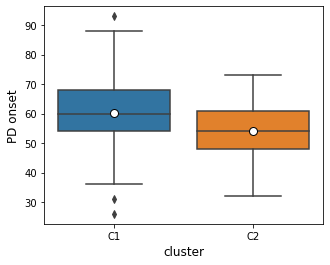

In [153]:
import matplotlib.pyplot as plt
import seaborn as sns

sex_colors = ["#00A6D6", "#FF69B4"]

fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(5, 4))

sns.boxplot(x="H", y="pdonset", data=data, showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"8"})
axs.set_ylabel('PD onset', fontsize=12)
axs.set_xlabel("cluster", fontsize=12)

plt.savefig("figures/pdonset_H.pdf", format="pdf", bbox_inches='tight')

##### Table

In [154]:
partition = "H"
columns_1 = ["pdonset", partition]

data[columns_1].groupby([partition]).mean().round(2)
data[columns_1].groupby([partition]).std().round(2)

,pdonset
H,
C1,10.63
C2,9.34


##### Hypothesis test

In [155]:
from scipy.stats import mannwhitneyu as mw

cluster_1_data = data.loc[data["H"] == "C1", "pdonset"]
cluster_2_data = data.loc[data["H"] == "C2", "pdonset"]

mw(cluster_1_data, cluster_2_data).pvalue

3.162400122975115e-06

#### 8.5 - PD duration

##### Plot

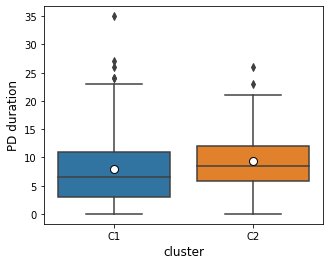

In [156]:
import matplotlib.pyplot as plt
import seaborn as sns

sex_colors = ["#00A6D6", "#FF69B4"]

fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(5, 4))

sns.boxplot(x="H", y="durat_pd", data=data, showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"8"})
axs.set_ylabel('PD duration', fontsize=12)
axs.set_xlabel("cluster", fontsize=12)

plt.savefig("figures/durat_pd_H.pdf", format="pdf", bbox_inches='tight')

##### Table

In [157]:
partition = "H"
columns_1 = ["durat_pd", partition]

data[columns_1].groupby([partition]).mean().round(2)
data[columns_1].groupby([partition]).std().round(2)

,durat_pd
H,
C1,6.00
C2,5.46


##### Hypothesis test

In [158]:
from scipy.stats import mannwhitneyu as mw

cluster_1_data = data.loc[data["H"] == "C1", "durat_pd"]
cluster_2_data = data.loc[data["H"] == "C2", "durat_pd"]

mw(cluster_1_data, cluster_2_data).pvalue

0.008196387929786808

#### 8.6 - Sex

##### Proportion table

Estimate the proportion of males and females in each cluster. The idea is to see if there are big proportional differences. This is not a hypothesis test.

In [159]:
import numpy as np

partition = "H"
columns_1 = ["sex", partition]

total_males = data["sex"].value_counts()[0]
total_females = data["sex"].value_counts()[1]
total = np.array([total_males, total_females, total_males, total_females])

(data[columns_1].groupby([partition]).sex.value_counts()/total * 100).round(2)

H   sex   
C1  male      83.20
    female    80.26
C2  male      16.80
    female    19.74
Name: sex, dtype: float64

##### Table

In [160]:
import numpy as np

partition = "H"
columns_1 = ["sex", partition]

cluster_1_total = data[columns_1].groupby([partition]).count().iloc[0,0]
cluster_2_total = data[columns_1].groupby([partition]).count().iloc[1,0]
total = np.array([cluster_1_total, cluster_1_total, cluster_2_total, cluster_2_total])

# Percentage
(data[columns_1].groupby([partition]).sex.value_counts()/total * 100).round(2) 
# Counts
#data[columns_1].groupby([partition]).sex.value_counts()

H   sex   
C1  male      63.03
    female    36.97
C2  male      58.33
    female    41.67
Name: sex, dtype: float64

##### Hypothesis test

https://stats.stackexchange.com/questions/110718/chi-squared-test-with-scipy-whats-the-difference-between-chi2-contingency-and

In [161]:
from scipy.stats import chi2_contingency 

cluster_1_data = data.loc[data["H"] == "C1", "sex"].value_counts()
cluster_2_data = data.loc[data["H"] == "C2", "sex"].value_counts()

cluster_1_data_array = [cluster_1_data[0], cluster_1_data[1]]
cluster_2_data_array = [cluster_2_data[0], cluster_2_data[1]]
contingency_table = [cluster_1_data_array, cluster_2_data_array]

tat, p, dof, expected = chi2_contingency(contingency_table)
p

0.5414995168206

## 9 - Clustering I

* **Attributes:** sweating, anxiety

#### 9.1 - Prepare data for analysis

In [162]:
# First, we make this variable categorical so Pandas can order its states in the plot. Then we rename its categories accordingly (and reorder them if necessary)
data["I"] = data["I"].astype("category")
data["I"] = data["I"].cat.rename_categories({"0":"C2", "1": "C1"})
data["I"] = data["I"].cat.reorder_categories(['C1', 'C2'])

#### 9.2 - Hoehn Yahr

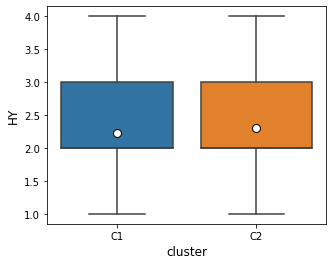

In [163]:
import matplotlib.pyplot as plt
import seaborn as sns

sex_colors = ["#00A6D6", "#FF69B4"]

fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(5, 4))

sns.boxplot(x="I", y="hy", data=data, showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"8"})
axs.set_ylabel('HY', fontsize=12)
axs.set_xlabel("cluster", fontsize=12)

plt.savefig("figures/hy_I.pdf", format="pdf", bbox_inches='tight')

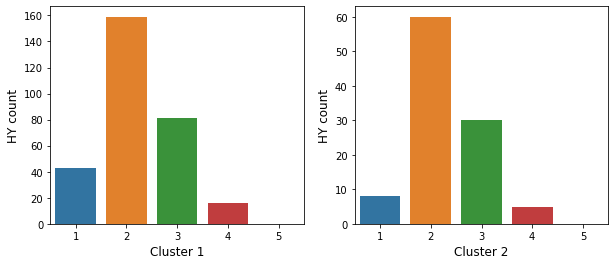

In [164]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 4))

sns.countplot(data.loc[data["I"] == "C1", "hy"], ax = axs[0], order=[1,2,3,4,5])
axs[0].set_xlabel("Cluster 1", fontsize=12)
axs[0].set_ylabel("HY count", fontsize=12)

sns.countplot(data.loc[data["I"] == "C2", "hy"], ax = axs[1], order=[1,2,3,4,5])
axs[1].set_xlabel("Cluster 2", fontsize=12)
axs[1].set_ylabel("HY count", fontsize=12)

plt.savefig("figures/hy_dists_I.pdf", format="pdf", bbox_inches='tight')

##### Hoehn Yahr table

In [165]:
partition = "I"
columns_1 = ["hy", partition]

data[columns_1].groupby([partition]).mean().round(2)
data[columns_1].groupby([partition]).std().round(2)

,hy
I,
C1,0.76
C2,0.69


##### Hypothesis test (continuous)

In [166]:
from scipy.stats import mannwhitneyu as mw

cluster_1_data = data.loc[data["I"] == "C1", "hy"]
cluster_2_data = data.loc[data["I"] == "C2", "hy"]

mw(cluster_1_data, cluster_2_data).pvalue

0.17643647380845184

##### Hypothesis test (discrete)

In [167]:
from scipy.stats import chi2_contingency 

cluster_1_data = data.loc[data["I"] == "C1", "hy"].value_counts()
cluster_2_data = data.loc[data["I"] == "C2", "hy"].value_counts()

# Given that in this dataset there are no HY values of 5, we consider only 4
cluster_1_data_array = [cluster_1_data.iloc[0], cluster_1_data.iloc[1], cluster_1_data.iloc[2], cluster_1_data.iloc[3]]
cluster_2_data_array = [cluster_2_data.iloc[0], cluster_2_data.iloc[1], cluster_2_data.iloc[2], cluster_2_data.iloc[3]]

contingency_table = [cluster_1_data_array, cluster_2_data_array]

tat, p, dof, expected = chi2_contingency(contingency_table)
p

0.36830502266705945

#### 9.3 - Age

##### Plot

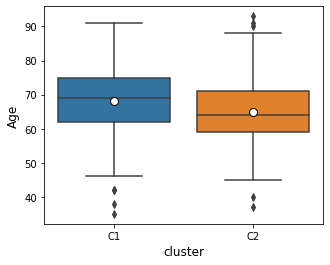

In [168]:
import matplotlib.pyplot as plt
import seaborn as sns

sex_colors = ["#00A6D6", "#FF69B4"]

fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(5, 4))

sns.boxplot(x="I", y="age", data=data, showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"8"})
axs.set_ylabel('Age', fontsize=12)
axs.set_xlabel("cluster", fontsize=12)

plt.savefig("figures/age_I.pdf", format="pdf", bbox_inches='tight')

##### Table

In [169]:
partition = "I"
columns_1 = ["age", partition]

data[columns_1].groupby([partition]).mean().round(2)
data[columns_1].groupby([partition]).std().round(2)

,age
I,
C1,9.67
C2,10.44


##### Hypothesis test

In [170]:
from scipy.stats import mannwhitneyu as mw

cluster_1_data = data.loc[data["I"] == "C1", "age"]
cluster_2_data = data.loc[data["I"] == "C2", "age"]

mw(cluster_1_data, cluster_2_data).pvalue

0.00077269290506343

#### 9.4 - PD onset

##### Plot

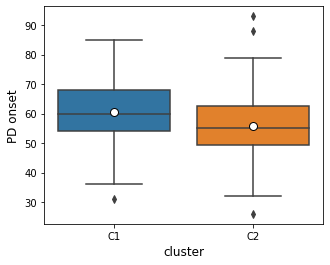

In [171]:
import matplotlib.pyplot as plt
import seaborn as sns

sex_colors = ["#00A6D6", "#FF69B4"]

fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(5, 4))

sns.boxplot(x="I", y="pdonset", data=data, showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"8"})
axs.set_ylabel('PD onset', fontsize=12)
axs.set_xlabel("cluster", fontsize=12)

plt.savefig("figures/pdonset_I.pdf", format="pdf", bbox_inches='tight')

##### Table

In [172]:
partition = "I"
columns_1 = ["pdonset", partition]

data[columns_1].groupby([partition]).mean().round(2)
data[columns_1].groupby([partition]).std().round(2)

,pdonset
I,
C1,10.31
C2,11.06


##### Hypothesis test

In [173]:
from scipy.stats import mannwhitneyu as mw

cluster_1_data = data.loc[data["I"] == "C1", "pdonset"]
cluster_2_data = data.loc[data["I"] == "C2", "pdonset"]

mw(cluster_1_data, cluster_2_data).pvalue

4.168754591909975e-05

#### 9.5 - PD duration

##### Plot

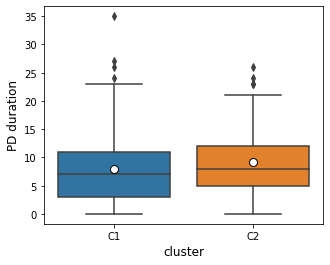

In [174]:
import matplotlib.pyplot as plt
import seaborn as sns

sex_colors = ["#00A6D6", "#FF69B4"]

fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(5, 4))

sns.boxplot(x="I", y="durat_pd", data=data, showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"8"})
axs.set_ylabel('PD duration', fontsize=12)
axs.set_xlabel("cluster", fontsize=12)

plt.savefig("figures/durat_pd_I.pdf", format="pdf", bbox_inches='tight')

##### Table

In [175]:
partition = "I"
columns_1 = ["durat_pd", partition]

data[columns_1].groupby([partition]).mean().round(2)
data[columns_1].groupby([partition]).std().round(2)

,durat_pd
I,
C1,5.99
C2,5.67


##### Hypothesis test

In [176]:
from scipy.stats import mannwhitneyu as mw

cluster_1_data = data.loc[data["I"] == "C1", "durat_pd"]
cluster_2_data = data.loc[data["I"] == "C2", "durat_pd"]

mw(cluster_1_data, cluster_2_data).pvalue

0.00925264930724717

#### 9.6 - Sex

##### Proportion table

Estimate the proportion of males and females in each cluster. The idea is to see if there are big proportional differences. This is not a hypothesis test.

In [177]:
import numpy as np

partition = "I"
columns_1 = ["sex", partition]

total_males = data["sex"].value_counts()[0]
total_females = data["sex"].value_counts()[1]
total = np.array([total_males, total_females, total_males, total_females])

(data[columns_1].groupby([partition]).sex.value_counts()/total * 100).round(2)

I   sex   
C1  male      76.00
    female    71.71
C2  male      24.00
    female    28.29
Name: sex, dtype: float64

##### Table

In [178]:
import numpy as np

partition = "I"
columns_1 = ["sex", partition]

cluster_1_total = data[columns_1].groupby([partition]).count().iloc[0,0]
cluster_2_total = data[columns_1].groupby([partition]).count().iloc[1,0]
total = np.array([cluster_1_total, cluster_1_total, cluster_2_total, cluster_2_total])

# Percentage
(data[columns_1].groupby([partition]).sex.value_counts()/total * 100).round(2) 
# Counts
#data[columns_1].groupby([partition]).sex.value_counts()

I   sex   
C1  male      63.55
    female    36.45
C2  male      58.25
    female    41.75
Name: sex, dtype: float64

##### Hypothesis test

https://stats.stackexchange.com/questions/110718/chi-squared-test-with-scipy-whats-the-difference-between-chi2-contingency-and

In [179]:
from scipy.stats import chi2_contingency 

cluster_1_data = data.loc[data["I"] == "C1", "sex"].value_counts()
cluster_2_data = data.loc[data["I"] == "C2", "sex"].value_counts()

cluster_1_data_array = [cluster_1_data[0], cluster_1_data[1]]
cluster_2_data_array = [cluster_2_data[0], cluster_2_data[1]]
contingency_table = [cluster_1_data_array, cluster_2_data_array]

tat, p, dof, expected = chi2_contingency(contingency_table)
p

0.4022959366479697